In [1]:
## Callin Switzer

## add points to a movie
## Extra Requirements: 
## -- opencv (to read and write video frames)
## -- ffmpeg (to convert video frames to a full movie)

In [1]:
import numpy as np
import cv2
import matplotlib
#matplotlib.use("TkAgg") # have to use this for tkinter to  work below
from matplotlib import pyplot as plt
%matplotlib inline
import skimage.io as io
import os
import time
import sys
from datetime import datetime
import pandas as pd

print("opencv version: %s" % cv2.__version__)
print("python version: %s" % sys.version[0:6])
print("last run: %s" % datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

opencv version: 3.4.1
python version: 3.6.5 
last run: 2019-05-15 19:01:02


In [2]:
# adjust gamma, if your vid is too dark
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [6]:
# read in video
vidPath = r"D:\Dropbox\AcademiaDropbox\dataAnalysisForOthers\MahadMovies\L0.1_c-3_m12.mp4"
#vidPath = r"/Users/cswitzer/Dropbox/AcademiaDropbox/dataAnalysisForOthers/MahadMovies/L0.1_c-3_m12.mp4"
if not os.path.isfile(vidPath): print("video doesn not exist")

#dataPath = r"D:\Dropbox\AcademiaDropbox\dataAnalysisForOthers\MahadMovies\Final_position_centroid_method_FirstTrial_L0.1_c-3_m12.csv"
dataPath = r"D:\Dropbox\AcademiaDropbox\dataAnalysisForOthers\MahadMovies\Final_position_centroid_method_LastTrial_L0.1_c-3_m12.csv"
#dataPath = r"/Users/cswitzer/Dropbox/AcademiaDropbox/dataAnalysisForOthers/MahadMovies/Final_position_centroid_method_LastTrial_L0.1_c-3_m12.csv"
if not os.path.isfile(dataPath): 
    print("dataset doesn not exist")  
else:
    dataPoints = pd.read_csv(dataPath, index_col  = 0)

dataPoints.head()

,FrameNumber,Name,X_position,Y_position
0,29811,L0.1_c-3_m12,NaN,NaN
1,29812,L0.1_c-3_m12,64.0,21.0
2,29813,L0.1_c-3_m12,NaN,NaN
3,29814,L0.1_c-3_m12,NaN,NaN
4,29815,L0.1_c-3_m12,45.0,14.0


In [7]:
# get vid info
cap = cv2.VideoCapture(vidPath)

length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)

print(length, width, height, fps)
cap.release()

97782 648 488 30.0


In [8]:
# data cleaning


In [9]:
dataPoints["X_filled"] = dataPoints["X_position"].interpolate().fillna(method = "ffill").fillna(method = "bfill")
dataPoints["Y_filled"] = dataPoints["Y_position"].interpolate().fillna(method = "ffill").fillna(method = "bfill")
dataPoints.head()

,FrameNumber,Name,X_position,Y_position,X_filled,Y_filled
0,29811,L0.1_c-3_m12,NaN,NaN,64.000000,21.000000
1,29812,L0.1_c-3_m12,64.0,21.0,64.000000,21.000000
2,29813,L0.1_c-3_m12,NaN,NaN,57.666667,18.666667
3,29814,L0.1_c-3_m12,NaN,NaN,51.333333,16.333333
4,29815,L0.1_c-3_m12,45.0,14.0,45.000000,14.000000


In [10]:
def load_imgs(vidPath, firstFrame, lastFrame):
    '''
    Reads frames from video and stores as a list
    
    Parameters: 
    vidPath (string): Path to video
    
    Returns: 
    list of images
    '''
    
    cap = cv2.VideoCapture(vidPath)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    imgs = []
    for ff in range(length):
        ret, frame = cap.read()
        if ff < firstFrame:
            continue
        elif ff >= lastFrame:
            break
        else:
            if np.mod(ff, 50) == 0:
                print(ff) # prints progress in 50 frames

            # convert to grey
            #img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            imgs.append(frame)
            
    cap.release()
    return imgs


# load images
imList = load_imgs(vidPath, np.min(dataPoints.FrameNumber), np.max(dataPoints.FrameNumber))

29850
29900
29950
30000
30050


In [11]:
# smooth with a rolling mean
dataPoints["Y_smoothed"] = dataPoints["Y_filled"].rolling(21, min_periods = 1, center = True).mean()
dataPoints["X_smoothed"] = dataPoints["X_filled"].rolling(21, min_periods = 1, center = True).mean()

In [12]:
# here's a little more smoothing -- a lowpass filter
# smooth data
from scipy import signal
b, a = signal.butter(10, 0.4, btype="low")

# Applies filter forward and backward in time
dataPoints["Y_smoothed2"] = signal.filtfilt(b, a, dataPoints.Y_smoothed)
dataPoints["X_smoothed2"] = signal.filtfilt(b, a, dataPoints.X_smoothed)

In [13]:
dataPoints.head()

,FrameNumber,Name,X_position,Y_position,X_filled,Y_filled,Y_smoothed,X_smoothed,Y_smoothed2,X_smoothed2
0,29811,L0.1_c-3_m12,NaN,NaN,64.000000,21.000000,15.363636,52.772727,15.362831,52.774159
1,29812,L0.1_c-3_m12,64.0,21.0,64.000000,21.000000,15.250000,53.208333,15.091757,53.111031
2,29813,L0.1_c-3_m12,NaN,NaN,57.666667,18.666667,14.692308,52.807692,14.977800,54.213284
3,29814,L0.1_c-3_m12,NaN,NaN,51.333333,16.333333,15.214286,57.535714,15.211757,56.196530
4,29815,L0.1_c-3_m12,45.0,14.0,45.000000,14.000000,16.333333,58.966667,15.947965,58.498686


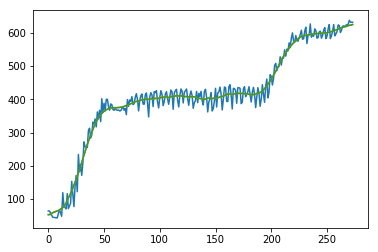

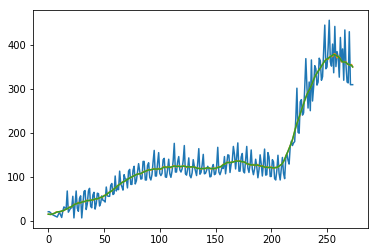

In [14]:
plt.plot(dataPoints.X_filled)
plt.plot(dataPoints["X_smoothed"])
plt.plot(dataPoints["X_smoothed2"])
plt.show()

plt.plot(dataPoints.Y_filled)
plt.plot(dataPoints["Y_smoothed"])
plt.plot(dataPoints["Y_smoothed2"])
plt.show()


(0, 488)

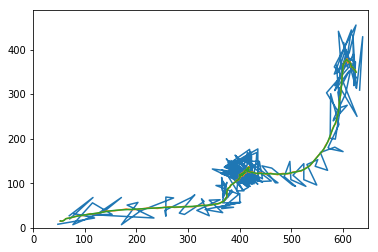

In [15]:
plt.plot(dataPoints.X_position, dataPoints.Y_position)
plt.plot(dataPoints.X_smoothed, dataPoints.Y_smoothed)
plt.plot(dataPoints.X_smoothed2, dataPoints.Y_smoothed2)
plt.xlim([0, width])
plt.ylim([0, height])

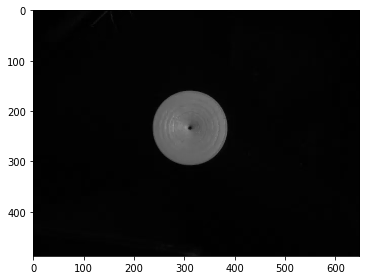

In [16]:
# show first image
io.imshow(imList[0])

In [17]:
imList[0].shape

(488, 648, 3)

In [18]:
# make directory to store images
tempImgDirectory = os.path.join(os.path.dirname(vidPath), "tmpImgs")
if not os.path.exists(tempImgDirectory):
    os.mkdir(tempImgDirectory)

# add circles up to XX points in the past

lagPoints = 50 # number of points to plot on each frame
alphaVals = np.flip(np.linspace(0, 0.2, lagPoints), axis = 0)
vidLen = len(imList)
outputImgs = []
for frameNum in np.arange(0, vidLen):
    
    # adjust gamma
    image = adjust_gamma(imList[frameNum], 1.5)
    
    # convert to rgb, so I can add colored points
    #image = cv2.cvtColor(im1,cv2.COLOR_GRAY2RGB)
    
    
    overlay = image.copy()
    output = image.copy()
    for jj in range(lagPoints):
        # add circle, centered at closest integer value
        cv2.circle(overlay, (int(dataPoints.X_smoothed2[np.max([frameNum-jj, 0])]), 
                             int(dataPoints.Y_smoothed2[np.max([frameNum-jj, 0])])), 
                   3, (219, 189, 166), -1)
        cv2.addWeighted(overlay, alphaVals[jj], output, 1 - alphaVals[jj],0, output)
    
    # invert color
    # output = cv2.bitwise_not(output)
    
    
    outputImgs.append(output)
    
    # display image -- it may be a bit faster if you don't display the images
    cv2.imshow('Output', output) 
     
    # save img
    cv2.imwrite(os.path.join(tempImgDirectory, str(frameNum).zfill(4) + ".png"), output)
    
    # Press Q on keyboard to  exit 
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break
    
    if np.mod(frameNum, 50) == 0:
        print(frameNum, " of ", vidLen)

cv2.destroyAllWindows()

0  of  273
50  of  273
100  of  273
150  of  273
200  of  273
250  of  273


In [60]:
# closes window on Mac
cv2.destroyAllWindows()
for i in range (1,5):
    cv2.waitKey(1)

In [35]:
# # you can make images larger: 
# output = cv2.resize(output, (width*2, height*2), interpolation=cv2.INTER_CUBIC)

In [19]:
# show a single image
cv2.namedWindow('Output')
cv2.imshow("Output", output)

# # destroy the window when the mouse clicks the "X"
while cv2.getWindowProperty('Output', cv2.WND_PROP_VISIBLE) == 1:
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break
cv2.destroyAllWindows()

In [20]:
# convert images to video with ffmpeg
os.chdir(tempImgDirectory)
print(tempImgDirectory)
# use ffmpeg to convert directory to video
# -r is output frame rate

# use -c:v mpeg4 for mac
# use -c:v libx264 on windows, and you don't need -b:v 10000k
os.system('ffmpeg -start_number 0 -r 50 -i %04d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v mpeg4  -b 10000k -pix_fmt yuv420p -y outputVid3_macVersion.mp4')

D:\Dropbox\AcademiaDropbox\dataAnalysisForOthers\MahadMovies\tmpImgs


0

In [24]:
# speed up video, without speeding up frame rate
os.system('ffmpeg -start_number 0 -r 60 -i %04d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v mpeg4 -filter:v "setpts=1.0*PTS"  -b 10000k -pix_fmt yuv420p -y output_FasterFPS.mp4')

0

In [ ]:
D:\Dropbox\AcademiaDropbox\dataAnalysisForOthers\MahadMovies\tmpImgs\outputVid3_macVersion.mp4

In [76]:
# delete images from directory
delFiles = [f for f in os.listdir(tempImgDirectory) if f.endswith("png")]

dlfs = [os.remove(os.path.join(tempImgDirectory, delFiles[ii])) for ii in range(len(delFiles))]